In [28]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Dataset directories
dataset_root = 'D:/gtsrb-german-traffic-sign/Train'
base_output_path = 'D:/traffic_sign_data'

In [3]:
# Custom directories for split dataset
train_path = os.path.join(base_output_path, 'training')
val_path = os.path.join(base_output_path, 'validation')
test_path = os.path.join(base_output_path, 'testing')

In [4]:
# Split each class directory
for label_dir in os.listdir(dataset_root):
    full_label_path = os.path.join(dataset_root, label_dir)
    if not os.path.isdir(full_label_path):
        continue

    all_images = [f for f in os.listdir(full_label_path) if f.endswith('.png')]
    train_imgs, temp_imgs = train_test_split(all_images, test_size=0.4, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for group, img_list in zip(['training', 'validation', 'testing'], [train_imgs, val_imgs, test_imgs]):
        class_out_path = os.path.join(base_output_path, group, label_dir)
        os.makedirs(class_out_path, exist_ok=True)
        for img_file in img_list:
            shutil.copy(os.path.join(full_label_path, img_file), os.path.join(class_out_path, img_file))

In [5]:
# Preprocessing function
def normalize_images(img):
    return img / 255.0

In [6]:
# Image dimensions and batch size
image_dim = 128
batch_val = 32

In [7]:
# Image data generators
data_generator = ImageDataGenerator(preprocessing_function=normalize_images)

In [8]:
train_loader = data_generator.flow_from_directory(
    train_path,
    target_size=(image_dim, image_dim),
    batch_size=batch_val,
    class_mode='categorical'
)

Found 23525 images belonging to 43 classes.


In [9]:
val_loader = data_generator.flow_from_directory(
    val_path,
    target_size=(image_dim, image_dim),
    batch_size=batch_val,
    class_mode='categorical'
)

Found 7842 images belonging to 43 classes.


In [10]:
test_loader = data_generator.flow_from_directory(
    test_path,
    target_size=(image_dim, image_dim),
    batch_size=batch_val,
    class_mode='categorical',
    shuffle=False
)

Found 7842 images belonging to 43 classes.


In [11]:
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# CNN

In [12]:
# CNN model definition
model_cnn = Sequential()

# Input layer: accepts RGB images of shape (image_dim, image_dim, 3)
model_cnn.add(Input(shape=(image_dim, image_dim, 3)))

# First convolutional layer: detects low-level features using 64 filters of size 3x3
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))

# First max pooling layer: reduces spatial dimensions and computation, keeps key features
model_cnn.add(MaxPooling2D((2, 2)))

# Second convolutional layer: captures more complex features with another 64 filters
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))

# Second max pooling layer: further reduces spatial dimensions
model_cnn.add(MaxPooling2D((2, 2)))

# Third convolutional layer: increases depth with 128 filters for advanced feature detection
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))

# Third max pooling layer: compresses spatial data while retaining useful patterns
model_cnn.add(MaxPooling2D((2, 2)))

# Flatten layer: transforms 3D feature maps into a 1D vector for dense layers
model_cnn.add(Flatten())

# Dropout layer: drops 40% of neurons randomly during training to prevent overfitting
model_cnn.add(Dropout(0.4))

# First dense layer: learns complex representations with 128 neurons
model_cnn.add(Dense(128, activation='relu'))

# Second dense layer: learns intermediate-level features with 64 neurons
model_cnn.add(Dense(64, activation='relu'))

# Third dense layer: further processes data with another 64 neurons
model_cnn.add(Dense(64, activation='relu'))

# Output layer: softmax activation for multi-class classification
model_cnn.add(Dense(len(val_loader.class_indices), activation='softmax', dtype='float32'))

In [13]:
# Callbacks
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='Best_CNN_Model.keras', monitor='val_loss', save_best_only=True, mode='min')
]

In [14]:
# Compile model
model_cnn.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
)

In [15]:
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,339,179 (12.74 MB)

 Trainable params: 3,339,179 (12.74 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train model with 10 epochs
history_cnn = model_cnn.fit(
    train_loader,
    epochs=10,
    validation_data=val_loader,
    callbacks=callbacks_list
)

Epoch 1/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 491s 663ms/step - accuracy: 0.3418 - loss: 2.3448 - precision: 0.7720 - recall: 0.1993 - val_accuracy: 0.8055 - val_loss: 0.5899 - val_precision: 0.8783 - val_recall: 0.7499
Epoch 2/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 401s 545ms/step - accuracy: 0.8587 - loss: 0.4495 - precision: 0.9142 - recall: 0.8100 - val_accuracy: 0.9331 - val_loss: 0.2296 - val_precision: 0.9570 - val_recall: 0.9072
Epoch 3/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 324s 440ms/step - accuracy: 0.9431 - loss: 0.1897 - precision: 0.9569 - recall: 0.9266 - val_accuracy: 0.9591 - val_loss: 0.1457 - val_precision: 0.9716 - val_recall: 0.9482
Epoch 4/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 370s 423ms/step - accuracy: 0.9635 - loss: 0.1140 - precision: 0.9719 - recall: 0.9560 - val_accuracy: 0.9695 - val_loss: 0.1037 - val_precision: 0.9788 - val_recall: 0.9635
Epoch 5/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 257s 349ms/step - accuracy: 0.9685 - loss: 0.1039 - precision: 0.9745 - recall: 0.9632 - val_accuracy: 0

In [17]:
# Evaluate on test set
predictions = model_cnn.predict(test_loader)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_loader.classes

246/246 ━━━━━━━━━━━━━━━━━━━━ 78s 318ms/step


In [18]:
# Calculate accuracy score
cnn_accuracy = accuracy_score(true_classes, predicted_classes)
print("Test Accuracy Score:", cnn_accuracy:.4f)

Test Accuracy Score: 0.9830400408059169


In [19]:
precision = precision_score(true_classes, predicted_classes, average='macro')
print(f"Precision: {precision:.4f}")

Precision: 0.9811


In [20]:
recall = recall_score(true_classes, predicted_classes, average='macro')
print(f"Recall: {recall:.4f}")

Recall: 0.9819


In [21]:
f1 = f1_score(true_classes, predicted_classes, average='macro')
print(f"F1 Score:  {f1:.4f}")

F1 Score:  0.9812


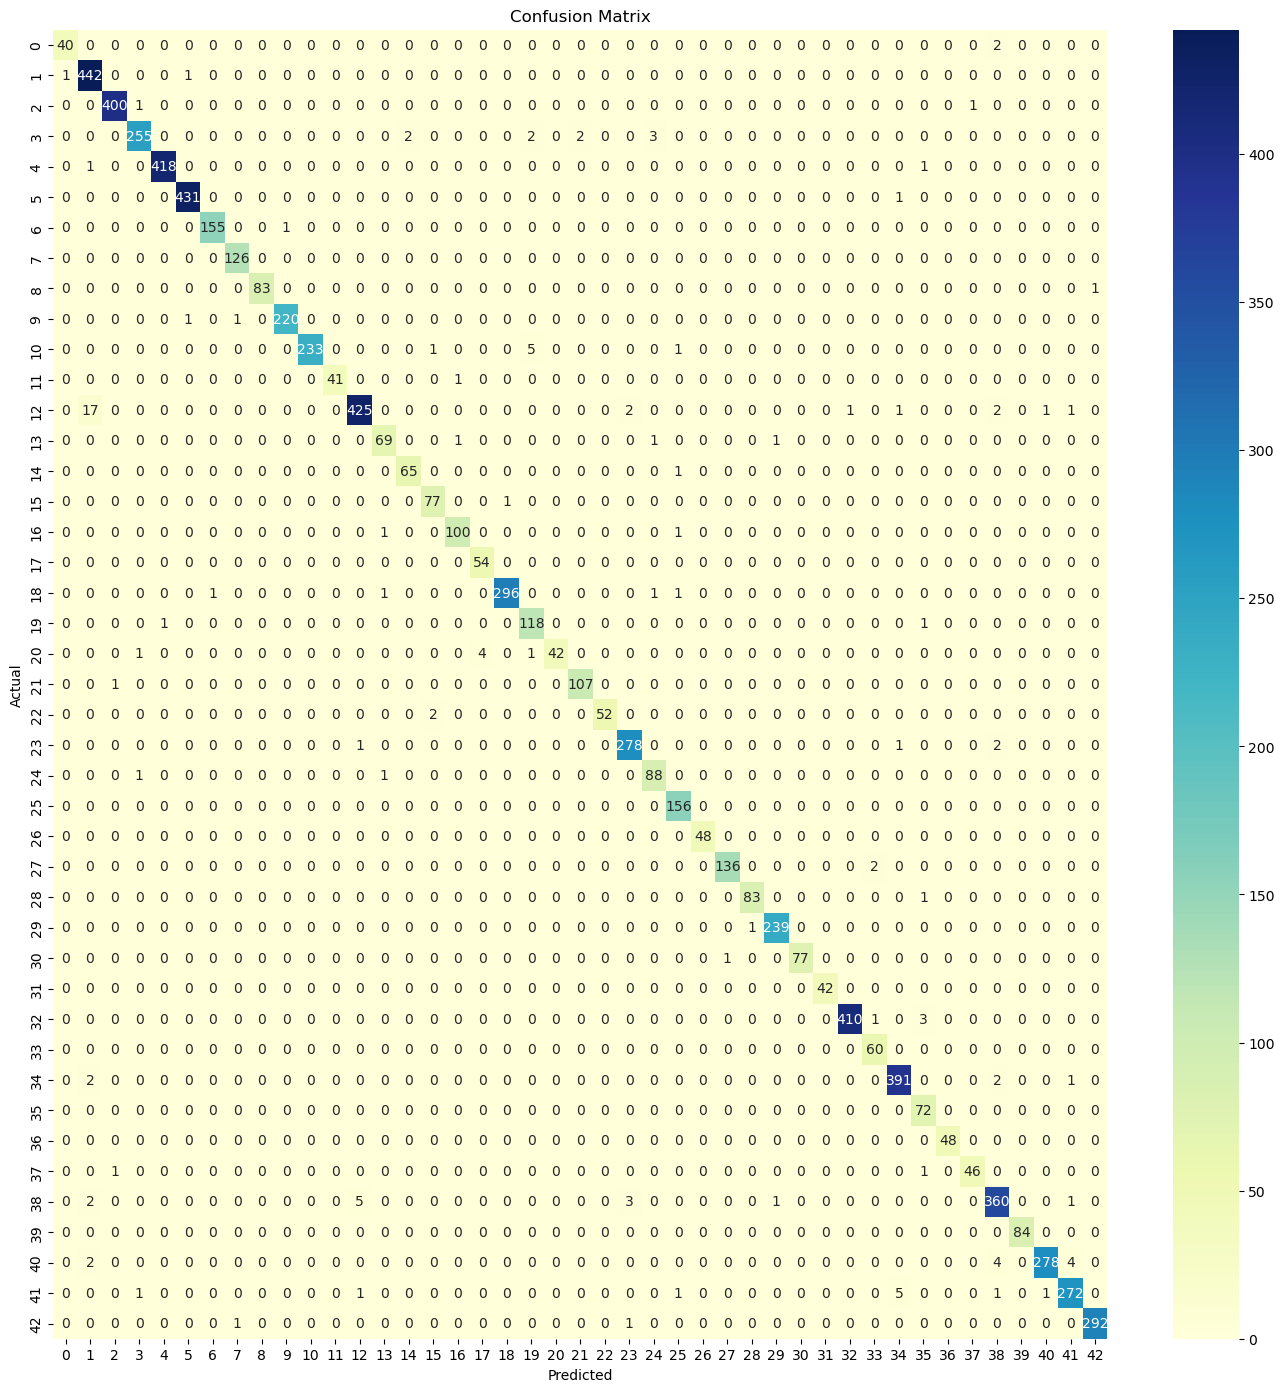

In [22]:
# Confusion matrix heatmap
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(17, 17))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

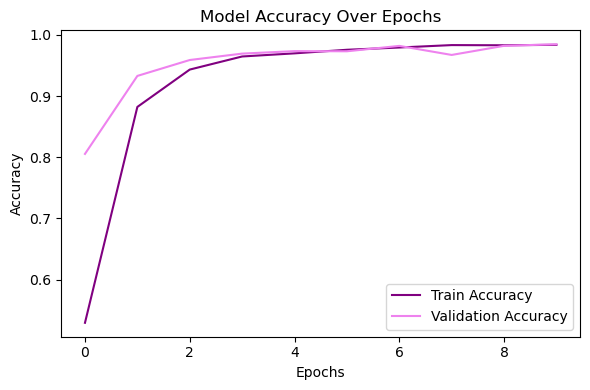

In [23]:
# Accuracy curve
plt.figure(figsize=(6, 4))
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy', color='purple')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy', color='violet')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

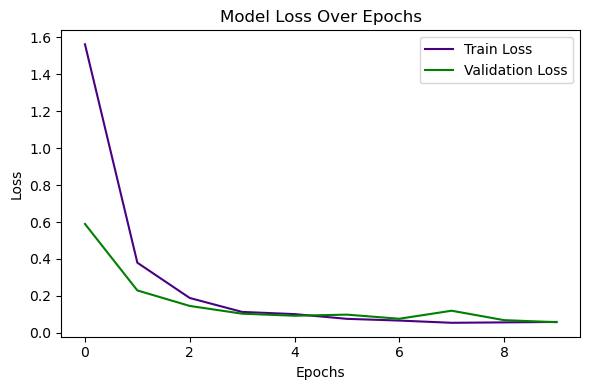

In [24]:
# Loss curve
plt.figure(figsize=(6, 4))
plt.plot(history_cnn.history['loss'], label='Train Loss', color='indigo')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss', color='green')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# MobileNetV2

In [25]:
# Define model
mobilenet_base = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
mobilenet_base.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [26]:
mobilenet_model = Sequential([
    mobilenet_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')  # GTSRB has 43 classes
])

In [29]:
mobilenet_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
mobilenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,499 (9.26 MB)

 Trainable params: 169,515 (662.17 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [32]:
# Define callbacks
mobilenet_callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('mobilenet_best_model.keras', save_best_only=True)  # <-- use .keras extension
]

In [33]:
# Train model
mobilenet_history = mobilenet_model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=10,
    steps_per_epoch=train_loader.samples // batch_val,
    validation_steps=val_loader.samples // batch_val,
    callbacks=mobilenet_callbacks
)

Epoch 1/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 1885s 3s/step - accuracy: 0.3682 - loss: 2.2919 - val_accuracy: 0.7360 - val_loss: 0.8545
Epoch 2/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 68s 91ms/step - accuracy: 0.5312 - loss: 1.3490 - val_accuracy: 0.7384 - val_loss: 0.8516
Epoch 3/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 393s 534ms/step - accuracy: 0.6576 - loss: 1.0714 - val_accuracy: 0.8143 - val_loss: 0.6368
Epoch 4/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 62s 84ms/step - accuracy: 0.6562 - loss: 0.9751 - val_accuracy: 0.8116 - val_loss: 0.6420
Epoch 5/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 292s 397ms/step - accuracy: 0.7302 - loss: 0.8325 - val_accuracy: 0.8364 - val_loss: 0.5018
Epoch 6/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 63s 85ms/step - accuracy: 0.8438 - loss: 0.5290 - val_accuracy: 0.8357 - val_loss: 0.5038
Epoch 7/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 251s 341ms/step - accuracy: 0.7673 - loss: 0.7042 - val_accuracy: 0.8651 - val_loss: 0.4426
Epoch 8/10
735/735 ━━━━━━━━━━━━━━━━━━━━ 62s 84ms/step - accuracy: 0.7812 - loss: 0.5

In [34]:
# Evaluate model
mobilenet_preds = mobilenet_model.predict(test_loader)
y_pred_mobile = np.argmax(mobilenet_preds, axis=1)
y_true_mobile = test_loader.classes

246/246 ━━━━━━━━━━━━━━━━━━━━ 167s 665ms/step


In [35]:
# Evaluation of metrics
acc_mobile = accuracy_score(y_true_mobile, y_pred_mobile)
print(f"Accuracy:  {acc_mobile:.4f}")

Accuracy:  0.8659


In [36]:
prec_mobile = precision_score(y_true_mobile, y_pred_mobile, average='macro')
print(f"Precision: {prec_mobile:.4f}")

Precision: 0.8933


In [37]:
rec_mobile = recall_score(y_true_mobile, y_pred_mobile, average='macro')
print(f"Recall:    {rec_mobile:.4f}")

Recall:    0.8409


In [38]:
f1_mobile = f1_score(y_true_mobile, y_pred_mobile, average='macro')
print(f"F1 Score:  {f1_mobile:.4f}")

F1 Score:  0.8609


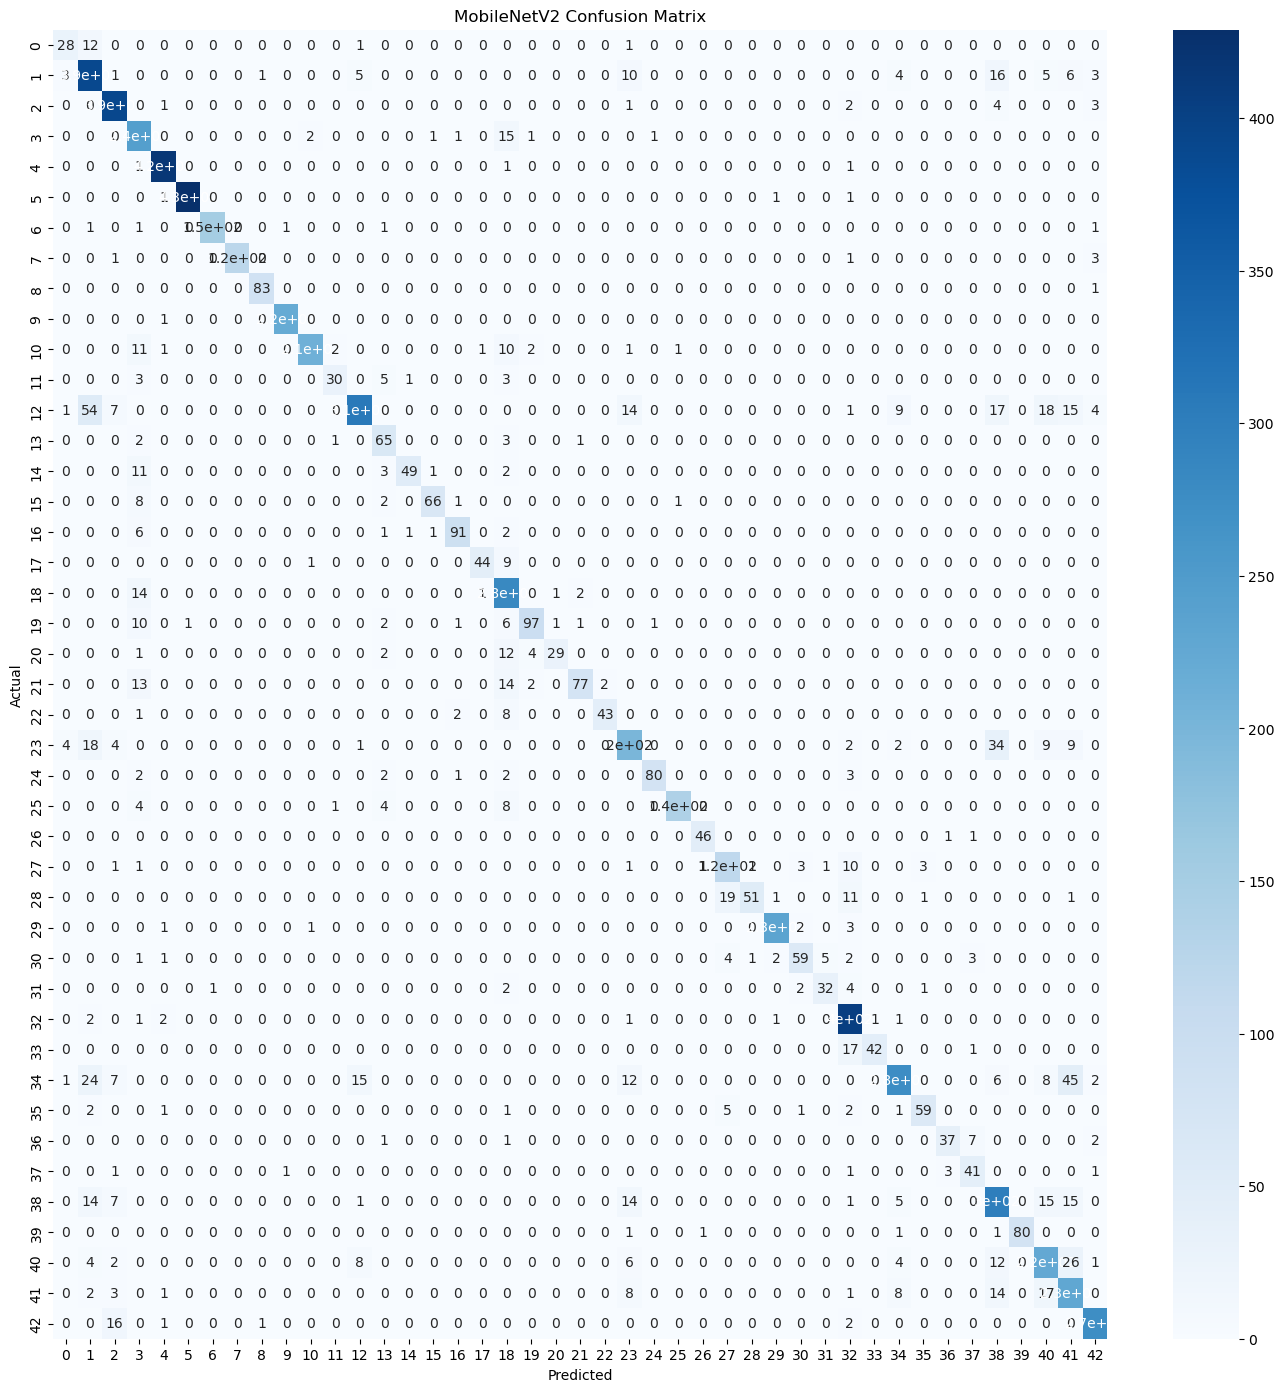

In [58]:
# Confusion matrix
cm_mobile = confusion_matrix(y_true_mobile, y_pred_mobile)
plt.figure(figsize=(17, 17))
sns.heatmap(cm_mobile, annot=True, cmap='Blues')
plt.title("MobileNetV2 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

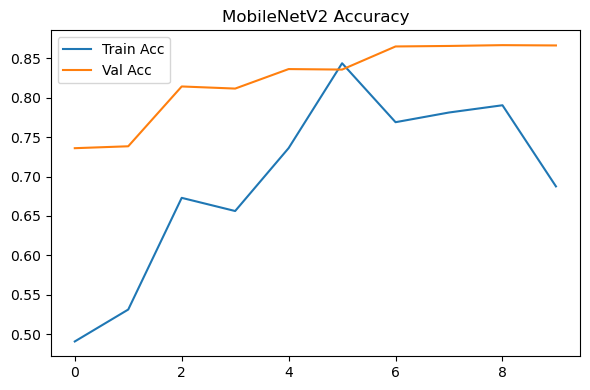

In [59]:
# Plot training history
plt.figure(figsize=(6,4))
plt.plot(mobilenet_history.history['accuracy'], label='Train Acc')
plt.plot(mobilenet_history.history['val_accuracy'], label='Val Acc')
plt.title('MobileNetV2 Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

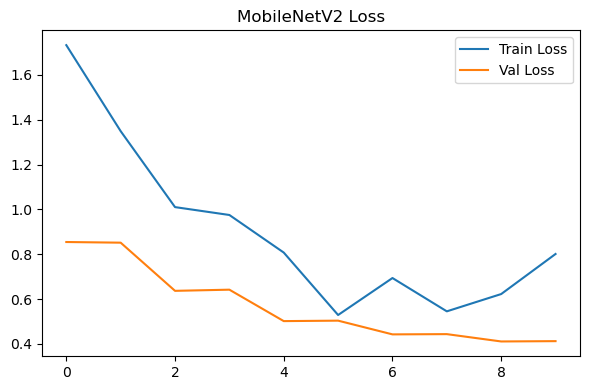

In [60]:
plt.figure(figsize=(6,4))
plt.plot(mobilenet_history.history['loss'], label='Train Loss')
plt.plot(mobilenet_history.history['val_loss'], label='Val Loss')
plt.title('MobileNetV2 Loss')
plt.legend()
plt.tight_layout()
plt.show()